In [28]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fluoz1","key":"7dc2f17055ded1684f8c5b34fc08a522"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d zarkonium/synthetic-image-dataset-cats-dogs-bikes-cars

 98% 316M/321M [00:04<00:00, 95.8MB/s]
100% 321M/321M [00:04<00:00, 70.3MB/s]


In [5]:
!mkdir dataset
!unzip -qq synthetic-image-dataset-cats-dogs-bikes-cars.zip -d dataset
!ls dataset

bikes  cars  cats  dogs


In [6]:
import os

dataset = os.path.basename('dataset')

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2
                    )
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2)

In [21]:
train_generator = train_datagen.flow_from_directory(
        dataset, 
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        subset='training',
        batch_size = 48,
        shuffle = True,
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
        dataset, 
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        subset='validation',
        batch_size =48,
        shuffle = True,
        class_mode='categorical')

Found 20000 images belonging to 4 classes.
Found 5000 images belonging to 4 classes.


In [22]:
model = tf.keras.models.Sequential([                                              
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),                        
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),                         
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),                                                    
    tf.keras.layers.Dropout(0.5), # menggunakan Dropout Regularization
    tf.keras.layers.Dense(128, activation='relu'),                                
    tf.keras.layers.Dense(512, activation='relu'),                                
    tf.keras.layers.Dense(4, activation='softmax')                        
])

model.summary()  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
from keras.callbacks import LearningRateScheduler
# menghentikan fit model ketika akurasi = 97

class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy')>0.92):
      print("Fit Berhenti Karena Akurasi Melebihi 92%")
      self.model.stop_training = True

callbacks = callback()

In [25]:
model_fit = model.fit(
      train_generator,
      steps_per_epoch=25,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2,
      callbacks=[callbacks],
      )

model_fit

Epoch 1/50
25/25 - 42s - loss: 0.2339 - accuracy: 0.9017 - val_loss: 0.1960 - val_accuracy: 0.9250 - 42s/epoch - 2s/step
Epoch 2/50
25/25 - 39s - loss: 0.2589 - accuracy: 0.8883 - val_loss: 0.3251 - val_accuracy: 0.8708 - 39s/epoch - 2s/step
Epoch 3/50
25/25 - 39s - loss: 0.3032 - accuracy: 0.8801 - val_loss: 0.3072 - val_accuracy: 0.8708 - 39s/epoch - 2s/step
Epoch 4/50
25/25 - 39s - loss: 0.2376 - accuracy: 0.9058 - val_loss: 0.3089 - val_accuracy: 0.8625 - 39s/epoch - 2s/step
Epoch 5/50
25/25 - 39s - loss: 0.2341 - accuracy: 0.9058 - val_loss: 0.1882 - val_accuracy: 0.9125 - 39s/epoch - 2s/step
Epoch 6/50
25/25 - 39s - loss: 0.2360 - accuracy: 0.9108 - val_loss: 0.1658 - val_accuracy: 0.9208 - 39s/epoch - 2s/step
Epoch 7/50
25/25 - 39s - loss: 0.2640 - accuracy: 0.8950 - val_loss: 0.2690 - val_accuracy: 0.9083 - 39s/epoch - 2s/step
Epoch 8/50
25/25 - 39s - loss: 0.2317 - accuracy: 0.9100 - val_loss: 0.2220 - val_accuracy: 0.9292 - 39s/epoch - 2s/step
Epoch 9/50
25/25 - 39s - loss: 0

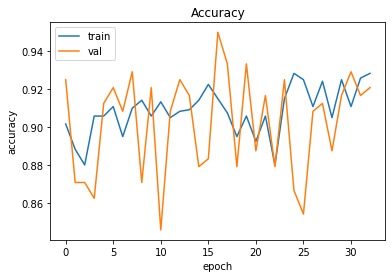

In [29]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

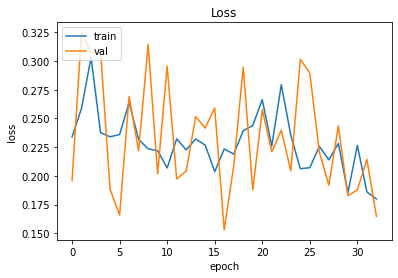

In [31]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [33]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root   9972256 Oct  2 10:02 model.tflite
